# Predict Bank Transaction Category Challenge

## Data Loading and Initial Inspection

In [ ]:
# Connect Drive to Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack
from sklearn.model_selection import GridSearchCV

In [ ]:
# Load datasets
transactions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MLS Assessment Datasets/bank_transaction.csv')
profiles = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MLS Assessment Datasets/user_profile.csv')

In [ ]:
# Display the first few rows of each dataset
print(transactions.head())
print(profiles.head())

   client_id  bank_id  account_id  txn_id             txn_date  \
0          1        1           1       4  2023-09-29 00:00:00   
1          1        1           1       3  2023-08-14 00:00:00   
2          1        1           1       5  2023-09-25 00:00:00   
3          1        1           2       1  2023-06-02 00:00:00   
4          1        1           2       2  2023-06-01 00:00:00   

                                         description  amount         category  
0  Earnin           PAYMENT                 Donat...    20.0            Loans  
1  ONLINE TRANSFER FROM NDonatas DanyalDA O CARSO...    25.0  Transfer Credit  
2  MONEY TRANSFER                          AUTHOR...    20.0            Loans  
3  ONLINE TRANSFER FROM CARSON N EVERYDAY CHECKIN...    16.0  Transfer Credit  
4  ONLINE TRANSFER FROM CARSON N EVERYDAY CHECKIN...     4.0  Transfer Credit  
   CLIENT_ID  IS_INTERESTED_INVESTMENT  IS_INTERESTED_BUILD_CREDIT  \
0          1                     False               

In [ ]:
# Check for missing values
print(transactions.isnull().sum())
print(profiles.isnull().sum())

client_id        0
bank_id          0
account_id       0
txn_id           0
txn_date         0
description      0
amount           0
category       257
dtype: int64
CLIENT_ID                        0
IS_INTERESTED_INVESTMENT         0
IS_INTERESTED_BUILD_CREDIT       0
IS_INTERESTED_INCREASE_INCOME    0
IS_INTERESTED_PAY_OFF_DEBT       0
IS_INTERESTED_MANAGE_SPENDING    0
IS_INTERESTED_GROW_SAVINGS       0
dtype: int64


In [ ]:
# Print the number of rows and columns for each dataset
print(f"Transactions dataset: {transactions.shape[0]} rows, {transactions.shape[1]} columns")
print(f"Profiles dataset: {profiles.shape[0]} rows, {profiles.shape[1]} columns")

Transactions dataset: 258779 rows, 8 columns
Profiles dataset: 1000 rows, 7 columns


## Data Preprocessing

In [ ]:
# Drop missing values
transactions.dropna(inplace=True)
profiles.dropna(inplace=True)

In [ ]:
# Merge datasets on 'client_id' and 'CLIENT_ID'
data = pd.merge(transactions, profiles, left_on='client_id', right_on='CLIENT_ID')

In [ ]:
# Preprocess text data: Lowercase and remove punctuation
data['description'] = data['description'].str.lower().str.replace('[^\w\s]', '', regex=True)
data['description'].fillna('', inplace=True)

# Convert 'txn_date' to datetime with the correct format
data['txn_date'] = pd.to_datetime(data['txn_date'], format='%Y-%m-%d %H:%M:%S')

# Extract date and time features
data['year'] = data['txn_date'].dt.year
data['month'] = data['txn_date'].dt.month
data['day'] = data['txn_date'].dt.day
data['hour'] = data['txn_date'].dt.hour
data['minute'] = data['txn_date'].dt.minute
data['second'] = data['txn_date'].dt.second

## Visualizations

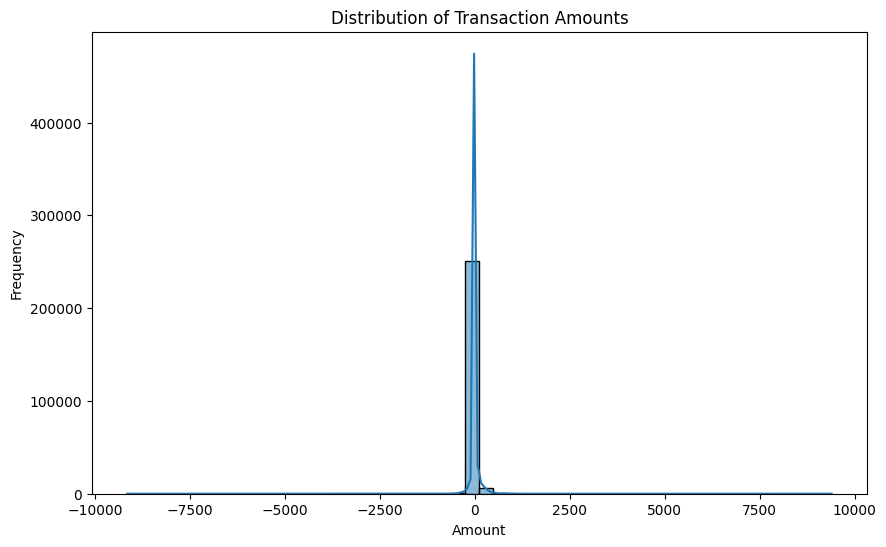

In [ ]:
# Visualize the distribution of transaction amounts to understand their spread and identify any outliers
plt.figure(figsize=(10, 6))
sns.histplot(data['amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

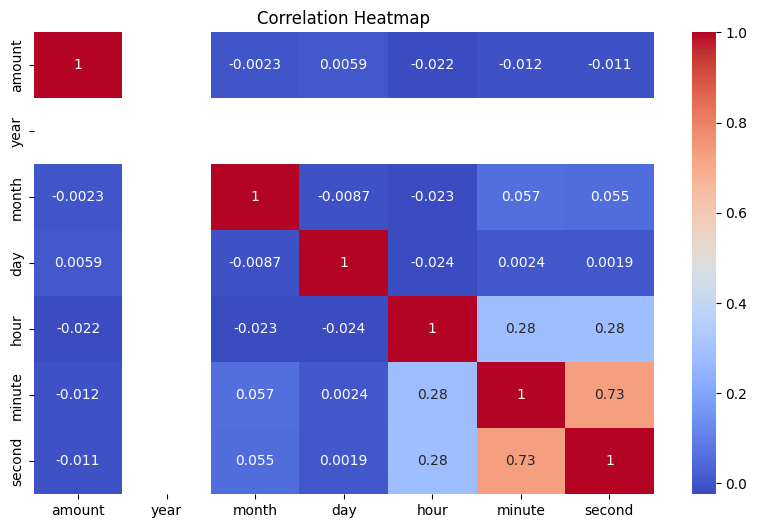

In [ ]:
# Visualize the correlation between numerical features to identify relationships between them
plt.figure(figsize=(10, 6))
sns.heatmap(data[['amount', 'year', 'month', 'day', 'hour', 'minute', 'second']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

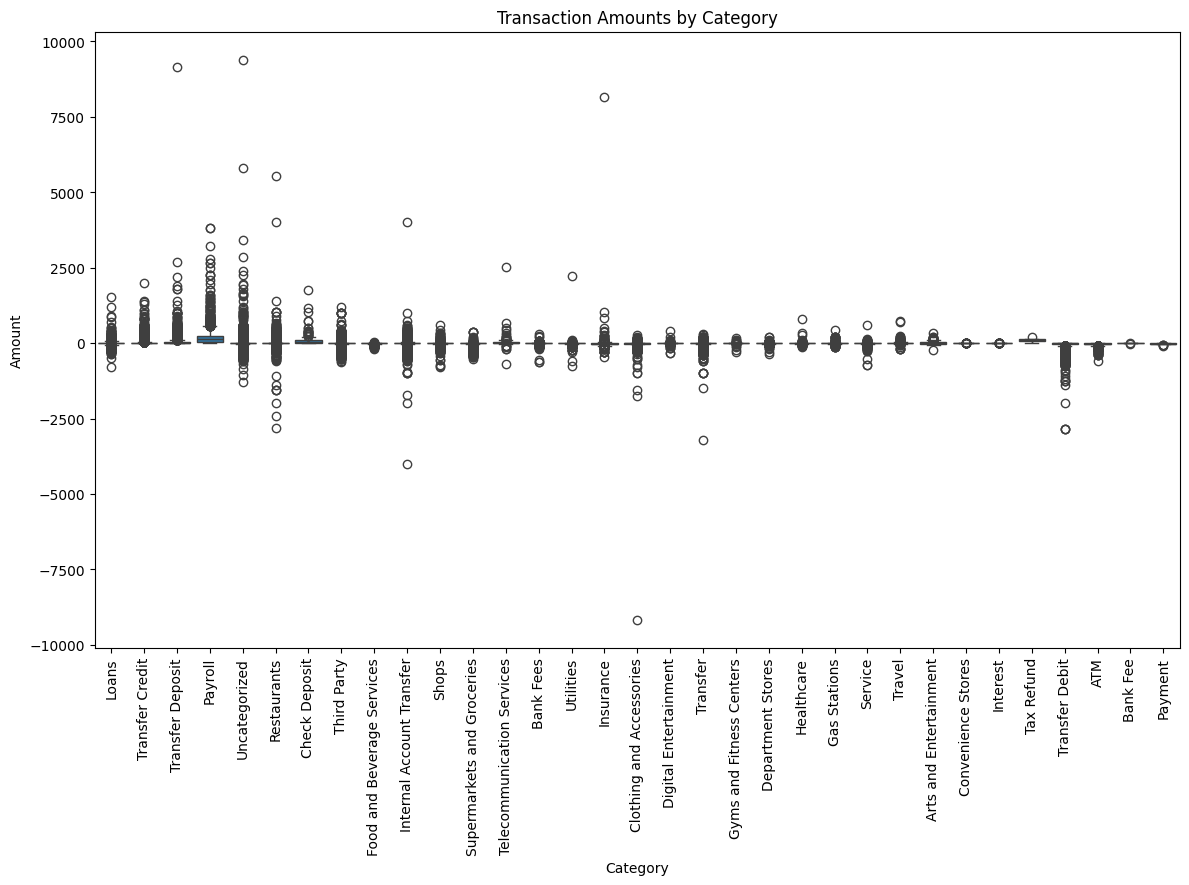

In [ ]:
# Boxplot of Transaction Amounts by Category
plt.figure(figsize=(14, 8))
sns.boxplot(x='category', y='amount', data=data)
plt.xticks(rotation=90)
plt.title('Transaction Amounts by Category')
plt.xlabel('Category')
plt.ylabel('Amount')
plt.show()

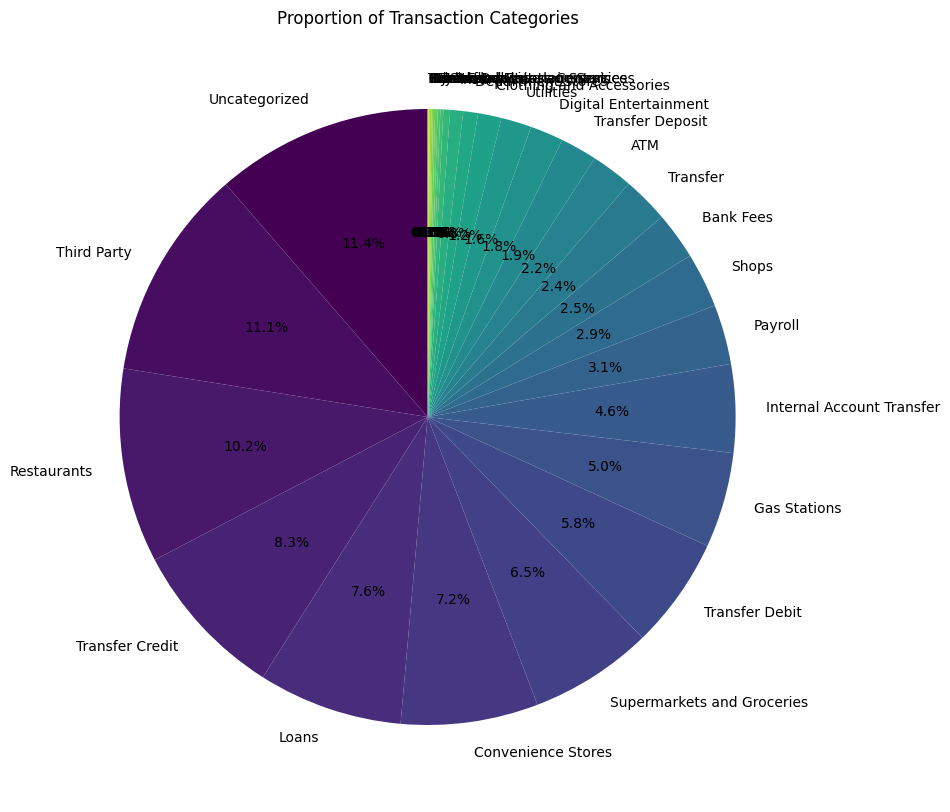

In [ ]:
# Show the proportion of each transaction category to understand their relative frequencies
plt.figure(figsize=(10, 10))
data['category'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='viridis')
plt.title('Proportion of Transaction Categories')
plt.ylabel('')
plt.show()

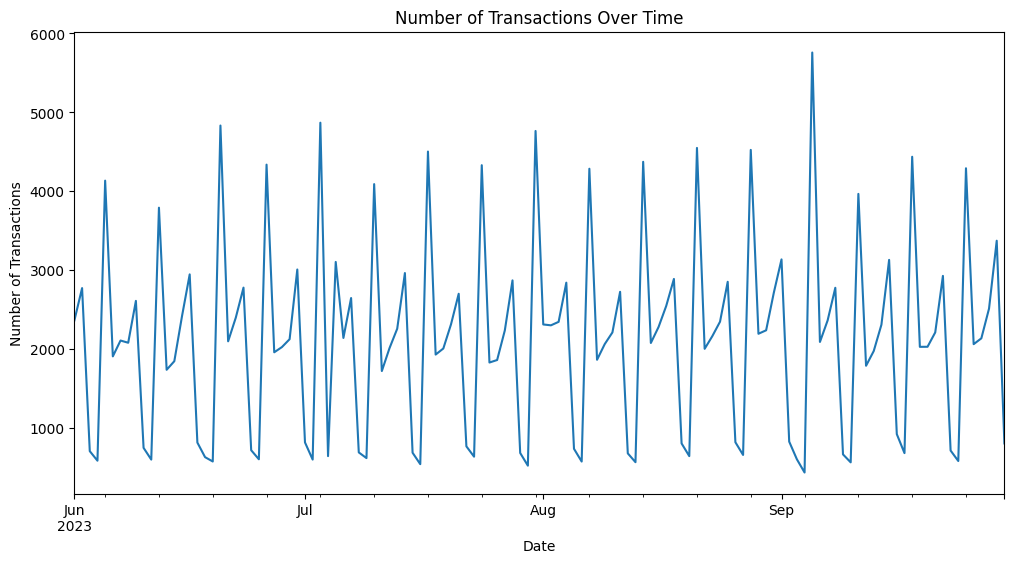

In [ ]:
# Show the number of transactions over time to identify trends and patterns
data['txn_date'] = pd.to_datetime(data['txn_date'])
data.set_index('txn_date', inplace=True)

transactions_per_day = data.resample('D').size()

plt.figure(figsize=(12, 6))
transactions_per_day.plot()
plt.title('Number of Transactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.show()

## Feature Engineering and Exploratory Data Analysis (EDA)

In [ ]:
# Use a smaller subset of the dataset for initial testing
data_sample = data.sample(frac=0.1, random_state=42)  # Use 10% of the data

# Text vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=500)  # Reduce max_features
X_text = tfidf_vectorizer.fit_transform(data_sample['description'])

# Explicitly select numerical and boolean features and ensure they are numeric
numerical_features = data_sample[['amount', 'year', 'month', 'day', 'hour', 'minute', 'second',
                                  'IS_INTERESTED_INVESTMENT', 'IS_INTERESTED_BUILD_CREDIT',
                                  'IS_INTERESTED_INCREASE_INCOME', 'IS_INTERESTED_PAY_OFF_DEBT',
                                  'IS_INTERESTED_MANAGE_SPENDING', 'IS_INTERESTED_GROW_SAVINGS']]

# Print column types for debugging
print(numerical_features.dtypes)

# Ensure all boolean features are converted to numeric (0 and 1)
numerical_features = numerical_features.astype(float)

# Combine text features with numerical features
X_numerical = numerical_features.values
X = hstack((X_text, X_numerical))
y = data_sample['category']

amount                           float64
year                               int32
month                              int32
day                                int32
hour                               int32
minute                             int32
second                             int32
IS_INTERESTED_INVESTMENT            bool
IS_INTERESTED_BUILD_CREDIT          bool
IS_INTERESTED_INCREASE_INCOME       bool
IS_INTERESTED_PAY_OFF_DEBT          bool
IS_INTERESTED_MANAGE_SPENDING       bool
IS_INTERESTED_GROW_SAVINGS          bool
dtype: object


In [ ]:
# Use a smaller subset of the dataset for initial testing
data_sample = data.sample(frac=0.1, random_state=42)  # Use 10% of the data

# Text vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=500)  # Reduce max_features
X_text = tfidf_vectorizer.fit_transform(data_sample['description'])

# Combine text features with numerical features
numerical_features = data_sample[['amount', 'year', 'month', 'day', 'hour', 'minute', 'second',
                                  'IS_INTERESTED_INVESTMENT', 'IS_INTERESTED_BUILD_CREDIT',
                                  'IS_INTERESTED_INCREASE_INCOME', 'IS_INTERESTED_PAY_OFF_DEBT',
                                  'IS_INTERESTED_MANAGE_SPENDING', 'IS_INTERESTED_GROW_SAVINGS']]

# Ensure all boolean features are converted to numeric (0 and 1)
numerical_features = numerical_features.astype(float)

# Ensure X_text is converted to float type
X_text = X_text.astype(float)

# Combine text features with numerical features
X = hstack((X_text, X_numerical))
y = data_sample['category']

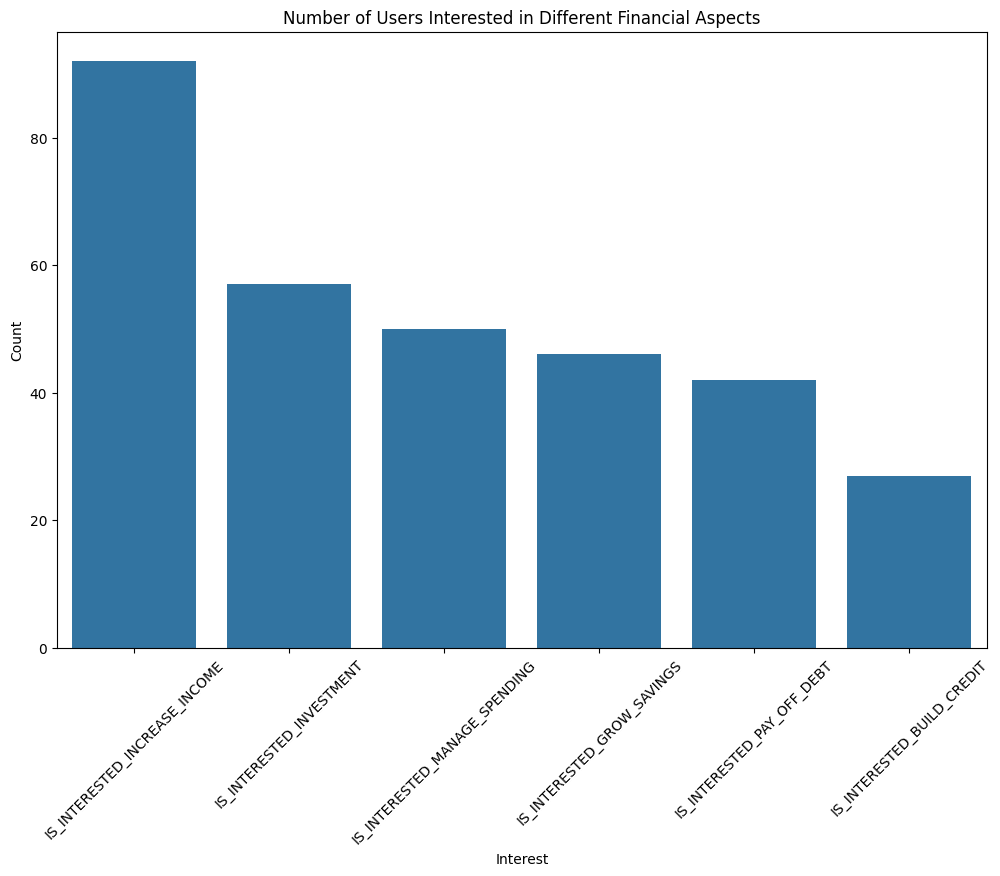

In [ ]:
# Drop the 'CLIENT_ID' column and select only the interest columns
interests = profiles.drop(columns=['CLIENT_ID'])

# Sum up the counts of users interested in each financial aspect
interest_counts = interests.sum().sort_values(ascending=False)

# Plot the distribution of user interests
plt.figure(figsize=(12, 8))
sns.barplot(x=interest_counts.index, y=interest_counts.values)
plt.title('Number of Users Interested in Different Financial Aspects')
plt.xlabel('Interest')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

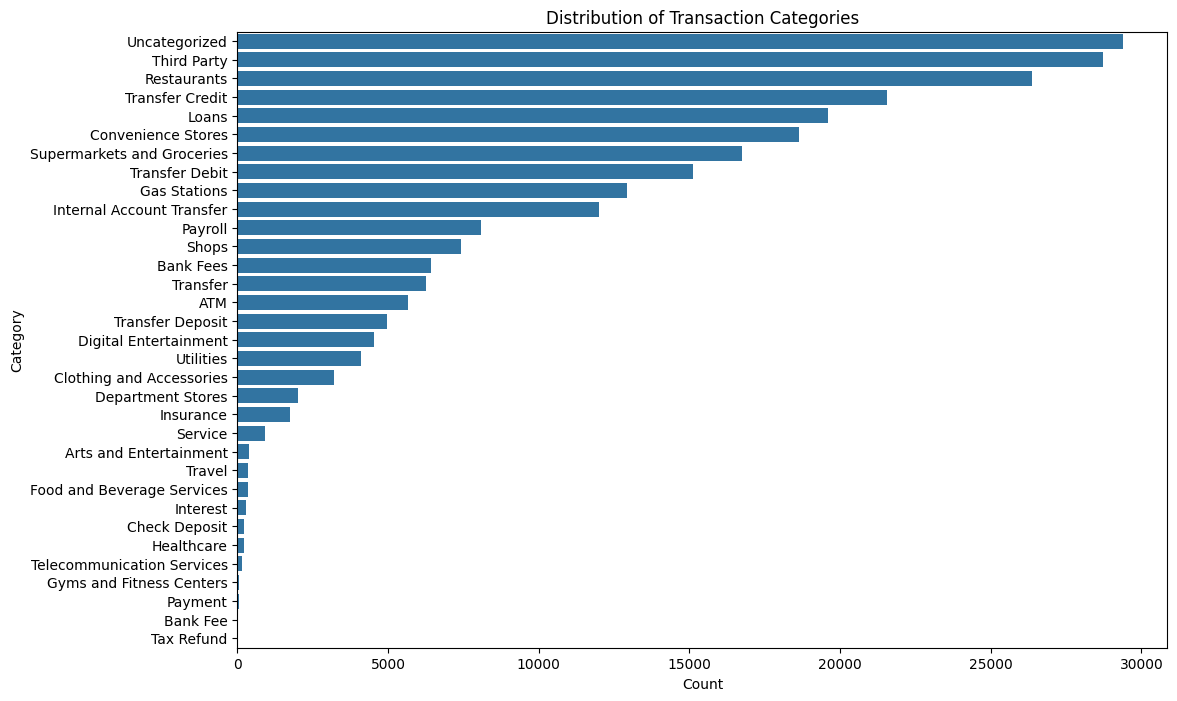

In [ ]:
# Plot the distribution of transaction categories in the transactions dataset
plt.figure(figsize=(12, 8))
sns.countplot(data=data, y='category', order=data['category'].value_counts().index)
plt.title('Distribution of Transaction Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

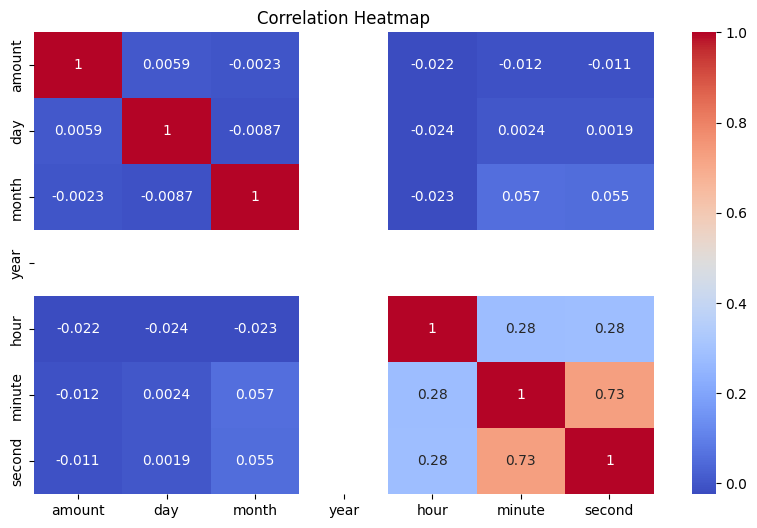

In [ ]:
# Correlation heatmap for numerical features
plt.figure(figsize=(10, 6))
sns.heatmap(data[['amount', 'day', 'month', 'year', 'hour', 'minute', 'second']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Model Training

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Model Evaluation

In [ ]:
# Predict and evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

                       ATM       0.97      1.00      0.99       109
    Arts and Entertainment       0.86      0.86      0.86         7
                 Bank Fees       0.92      0.94      0.93       138
             Check Deposit       1.00      1.00      1.00         5
  Clothing and Accessories       0.67      0.36      0.47        61
        Convenience Stores       0.71      0.85      0.77       373
         Department Stores       0.50      0.28      0.36        43
     Digital Entertainment       0.65      0.73      0.69        92
Food and Beverage Services       0.75      0.43      0.55         7
              Gas Stations       0.65      0.68      0.67       254
  Gyms and Fitness Centers       0.00      0.00      0.00         1
                Healthcare       1.00      0.25      0.40         4
                 Insurance       0.74      0.64      0.69        36
                  Interest       0.75      0.50

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.81434925546316


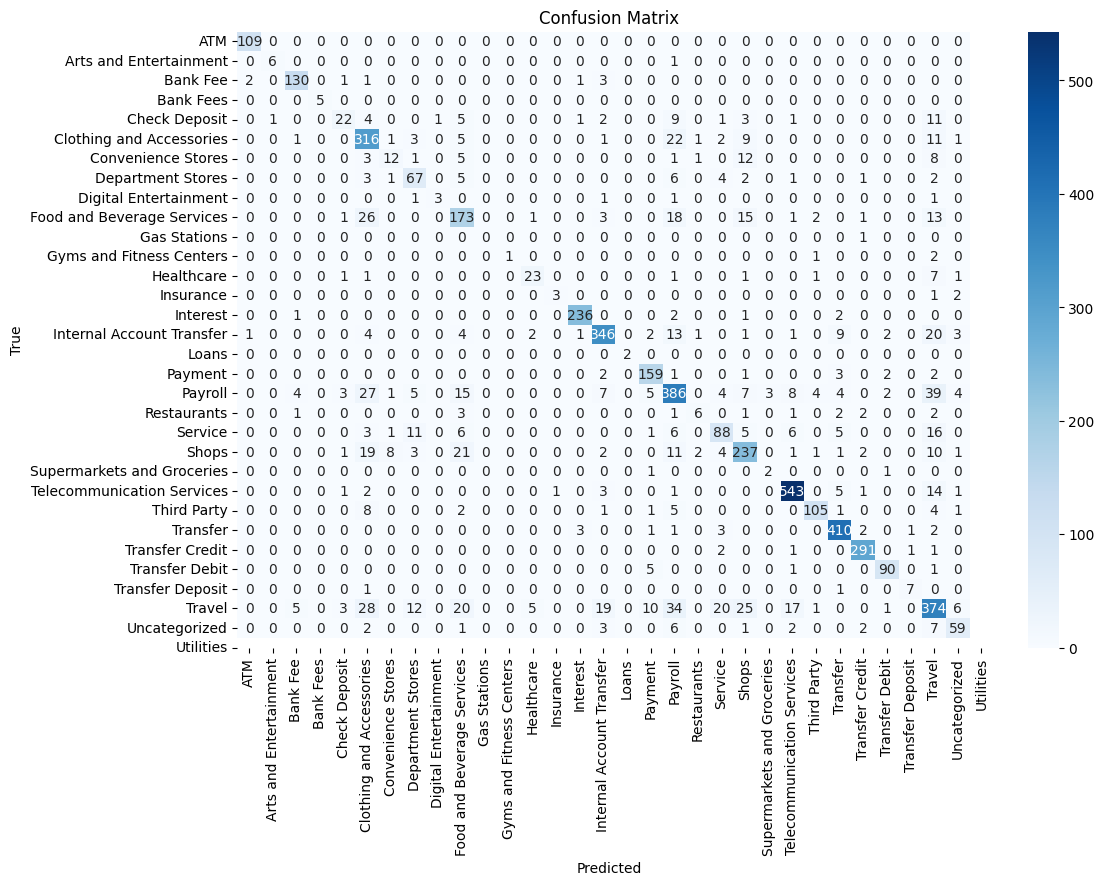

In [ ]:
# Visualize the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Hyperparameter Tuning

In [ ]:
# Define parameter grid for Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters from Grid Search
print("Best parameters found: ", grid_search.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Best parameters found:  {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}


In [ ]:
# Evaluate the best model from Grid Search
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Show the Classification Report of best model from Grid Search
print(classification_report(y_test, y_pred_best))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

                       ATM       0.97      1.00      0.99       109
    Arts and Entertainment       0.88      1.00      0.93         7
                 Bank Fees       0.93      0.93      0.93       138
             Check Deposit       1.00      1.00      1.00         5
  Clothing and Accessories       0.70      0.34      0.46        61
        Convenience Stores       0.70      0.87      0.77       373
         Department Stores       0.58      0.26      0.35        43
     Digital Entertainment       0.68      0.71      0.69        92
Food and Beverage Services       0.50      0.14      0.22         7
              Gas Stations       0.65      0.72      0.68       254
  Gyms and Fitness Centers       0.00      0.00      0.00         1
                Healthcare       1.00      0.25      0.40         4
                 Insurance       0.78      0.58      0.67        36
                  Interest       1.00      0.50

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


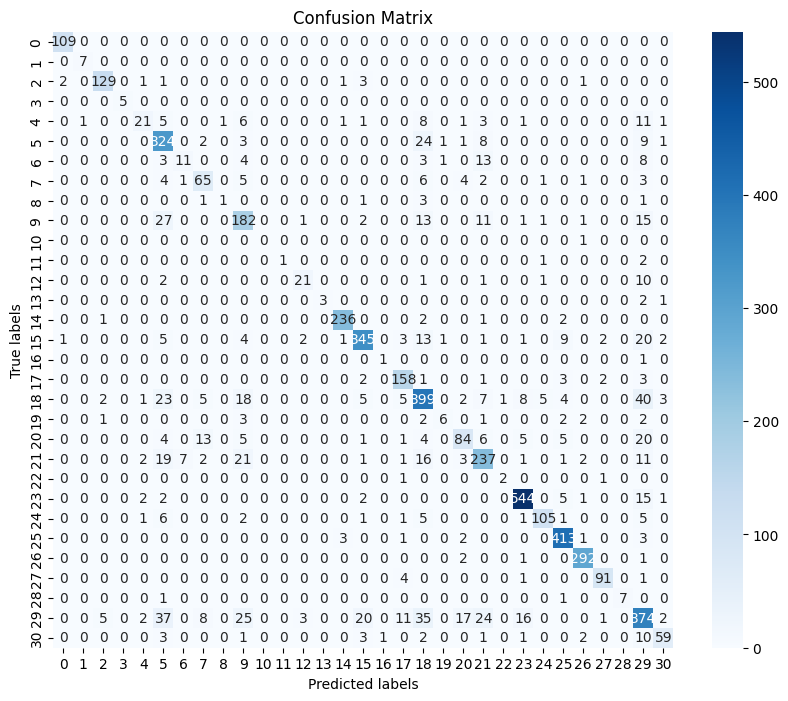

In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from joblib import dump

# Once your model is trained, save it to a file
model_filename = '/content/drive/MyDrive/Colab Notebooks/MLS Assessment Datasets/trained_RF_model.joblib'
dump(model, model_filename)

print(f"Model saved to {model_filename}")

Model saved to /content/drive/MyDrive/Colab Notebooks/MLS Assessment Datasets/trained_RF_model.joblib


# Conclusion

The Random Forest model achieved satisfactory performance in classifying transaction categories. The model's performance can be further enhanced through more sophisticated feature engineering and exploring advanced models like Gradient Boosting or Neural Networks.

# Future Work

## Next 1 Month
- Collect and incorporate more data for better model generalization.
- Enhance text preprocessing and try advanced text representation techniques (e.g., word embeddings).
- Perform extensive hyperparameter tuning and model selection.

## Next 3 Months
- Deploy the model for real-time prediction.
- Implement a feedback loop to continuously improve model performance.
- Optimize the model for scalability to handle larger datasets.